# Signal to noise calculations for the Australian Space Eye proposal

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import astropy.units as u

## Import gunagala

`gungala` is the library that performs the SNR/sensitivity/ETC calculations. The main submodule is `imager` which includes the `Imager` class which represents an astronomical imaging instrument.

In [7]:
from gunagala import imager

## Create imagers

The `gunagala.imager.create_imagers()` creates a dictionary of `Imager` objects based on the `gunagala/data/performance.yaml` configuration file as well as performance data files in `gunagala/data/performance_data`. The instrument configuration/specifications should be set by editing these files.

Currently the file describes 3 variants of the Australian Space Eye concept and, for comparison, a 5 lens version of the Huntsman Telephoto Array.

In [44]:
imagers = imager.create_imagers()

huntsman = imagers['canon_sbig']  # A 5 lens array

ase_2016 = imagers['ase_2016']  # 6U with 1x 90 mm telescope & overlapping broadband filters
ase_2017 = imagers['ase_2017']  # 6U with 1x 90 mm telescope & broad and narrowband filters

waves_h = huntsman.wavelengths
waves_a = ase_2016.wavelengths

## Inspect imager properties

Many properties of the imagers can be accessed as properties of the `Imager` object.

### Filter profiles 

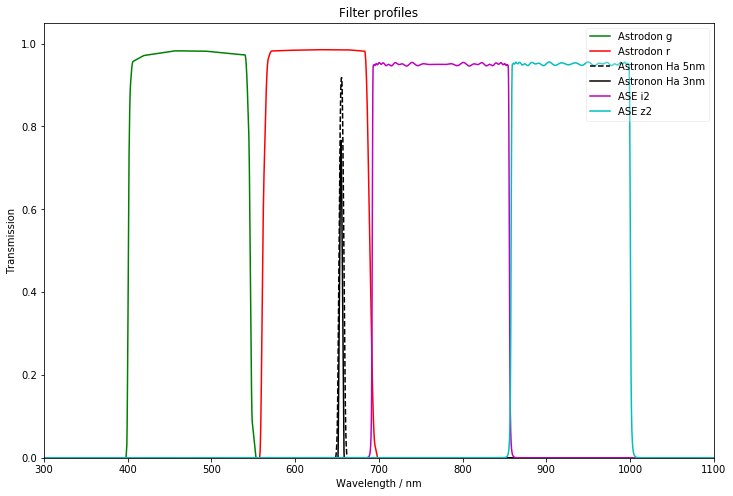

In [45]:
plt.plot(waves_h, huntsman.filters['g'].transmission(waves_h), 'g-', label='Astrodon g')
plt.plot(waves_h, huntsman.filters['r'].transmission(waves_h), 'r-', label='Astrodon r')
plt.plot(waves_h, huntsman.filters['Ha_5nm'].transmission(waves_h), 'k--', label='Astronon Ha 5nm')
plt.plot(waves_h, huntsman.filters['Ha_3nm'].transmission(waves_h), 'k-', label='Astronon Ha 3nm')


plt.plot(waves_a, ase_2016.filters['ase_i2'].transmission(waves_a), 'm-', label='ASE i2')
plt.plot(waves_a, ase_2016.filters['ase_z2'].transmission(waves_a), 'c-', label='ASE z2')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(300, 1100)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

In [40]:
ase_2017.filters['ase_nb689'].FWHM

<Quantity 2.325535494359997 nm>

In [41]:
ase_2017.filters['ase_nb689'].lambda_c

<Quantity 688.5476830823761 nm>

In [42]:
ase_2017.filters['ase_nb689'].lambda_peak

<Quantity [ 688.5466216] nm>

In [43]:
ase_2017.filters['ase_nb689'].peak

<Quantity [ 0.95054314]>

### Image sensor quantum efficiency

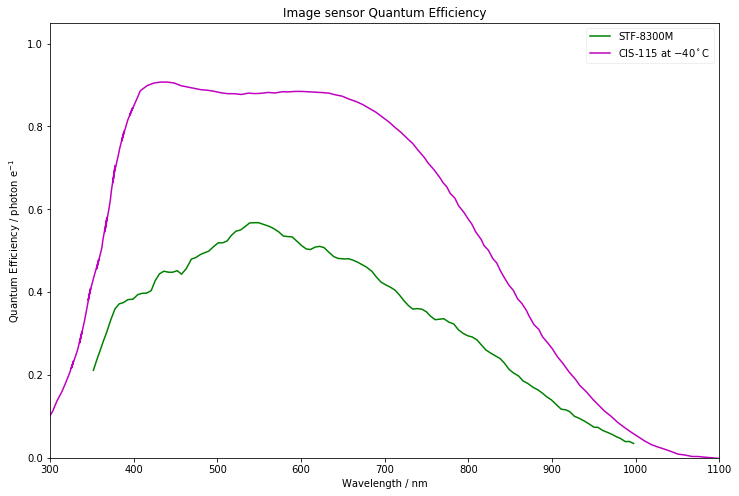

In [46]:
plt.plot(huntsman.camera.wavelengths, huntsman.camera.QE, 'g-', label='STF-8300M')
plt.plot(ase_2017.camera.wavelengths, ase_2017.camera.QE, 'm-', label='CIS-115 at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Quantum Efficiency / photon e$^{-1}$')
plt.title('Image sensor Quantum Efficiency')
plt.xlim(300, 1100)
plt.ylim(0,1.05)
plt.gcf().set_size_inches(12,8)

### End to end efficiency

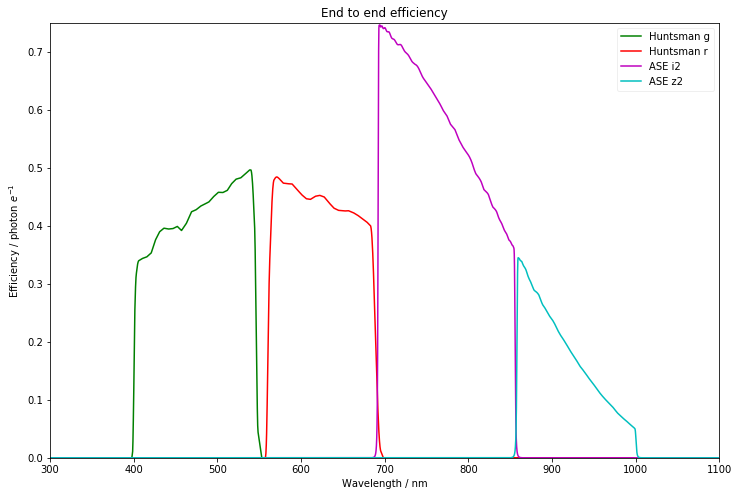

In [47]:
plt.plot(waves_h, huntsman.efficiencies['g'], 'g-', label='Huntsman g')
plt.plot(waves_h, huntsman.efficiencies['r'], 'r-', label='Huntsman r')

plt.plot(waves_a, ase_2017.efficiencies['ase_i2'], 'm-', label='ASE i2')
plt.plot(waves_a, ase_2017.efficiencies['ase_z2'], 'c-', label='ASE z2')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency / photon $e^{-1}$')
plt.title('End to end efficiency')
plt.xlim(300, 1100)
plt.ylim(0, 0.75)
plt.gcf().set_size_inches(12,8)

### Sky background model

For ASE the sky background is expected to dominated by the Zodiacal Light. For this we are use a scaled, reddened Solar spectrum following the prescription used by the HST ETC.

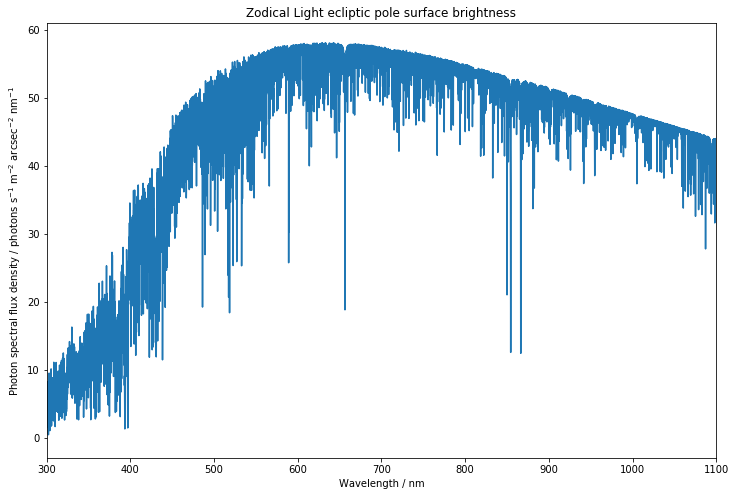

In [48]:
plt.plot(ase_2017.sky.waves.to(u.nm), ase_2017.sky.photon_sfd)
plt.xlim(300, 1100)
plt.title('Zodical Light ecliptic pole surface brightness')
plt.xlabel('Wavelength / nm')
plt.ylabel('Photon spectral flux density / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ nm$^{-1}$')
plt.gcf().set_size_inches(12, 8)

### Detected sky background levels

Pre-calculated for each filter. Also dark current for comparison.

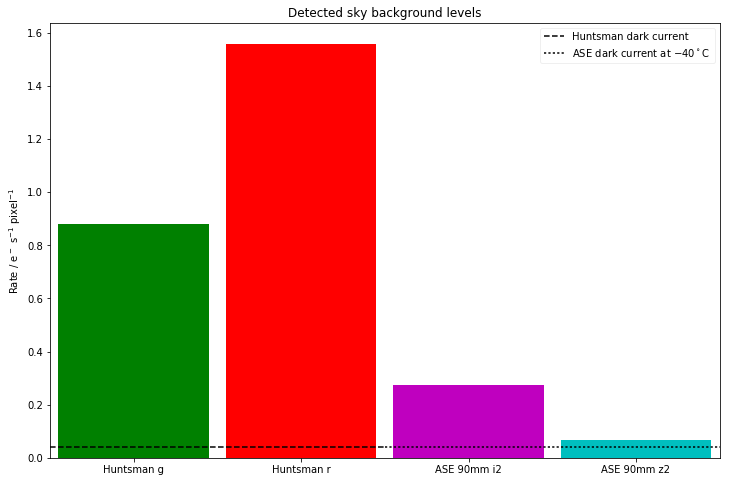

In [49]:
plt.bar((1, 2), (huntsman.sky_rate['g'].value, huntsman.sky_rate['r'].value),
        width=0.9, align='center', color=('g', 'r'))
plt.hlines(huntsman.camera.dark_current.value, 0.5, 2.5, linestyle='dashed', label='Huntsman dark current')

plt.bar((3, 4), (ase_2017.sky_rate['ase_i2'].value,
                       ase_2017.sky_rate['ase_z2'].value),
        width=0.9, align='center', color=('m', 'c'))
plt.hlines(ase_2017.camera.dark_current.value, 2.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xticks((1, 2, 3, 4), 
           ('Huntsman g', 'Huntsman r', 'ASE 90mm i2', 'ASE 90mm z2'))
plt.xlim(0.5,4.5)
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels')
plt.gcf().set_size_inches(12, 8)

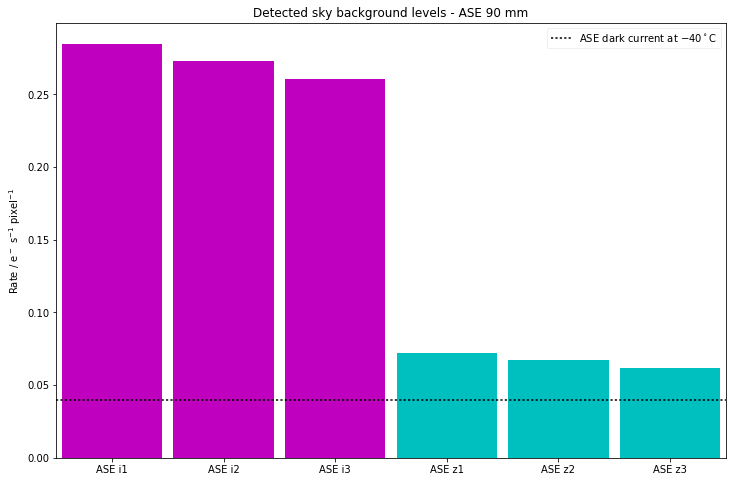

In [50]:
plt.bar((1, 2, 3, 4, 5, 6),
        (ase_2016.sky_rate['ase_i1'].value,
         ase_2016.sky_rate['ase_i2'].value,
         ase_2016.sky_rate['ase_i3'].value,
         ase_2016.sky_rate['ase_z1'].value,
         ase_2016.sky_rate['ase_z2'].value,
         ase_2016.sky_rate['ase_z3'].value),
        width=0.9, align='center', color=('m', 'm', 'm', 'c', 'c', 'c'))
plt.hlines(ase_2016.camera.dark_current.value, 0.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlim(0.5,6.5)
plt.xticks((1, 2, 3, 4, 5, 6), ('ASE i1', 'ASE i2', 'ASE i3', 'ASE z1', 'ASE z2', 'ASE z3'))
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels - ASE 90 mm')

plt.gcf().set_size_inches(12, 8)

## Broadband imaging sensitivity

For broadband i and z band imaging we combine the data from all the i band and all the z band filters together meaning that half the exposure time goes to i and half to z.

We expect to observe for approximately 40 minutes of each 100 minute orbit.  Individual sub exposures that therefore be up to 40 minutes long, cosmic rays permitting.

Nominal mission duration is 2 years, allowing up to several months on each target field.

In [51]:
duty_cycle = 40 / 100
filter_fraction = 3 / 6

### Basic extended source sensitivity, 3 months

Limiting surface brightness in AB magnitudes per square arcsecond given a signal to noise ratio threshold of 1.0 per arcsecond squared and 3 months on target.

#### 6U ASE with 1x 90 mm telescope

In [52]:
ase_2017.extended_source_limit(total_exp_time = 3 * 30 * u.day * duty_cycle * filter_fraction,
                               sub_exp_time = 40 * u.minute,
                               filter_name = 'ase_i2',
                               snr_target=1.0,
                               calc_type='per arcsecond squared')

<Magnitude 29.75396417807755 mag(AB)>

In [53]:
ase_2017.extended_source_limit(total_exp_time = 3 * 30 * u.day * duty_cycle * filter_fraction,
                               sub_exp_time = 40 * u.minute,
                               filter_name = 'ase_z2',
                               snr_target=1.0,
                               calc_type='per arcsecond squared')

<Magnitude 28.70152445788573 mag(AB)>

### Extended source sensitivity, 3 months with binning

Our highest priority science targets will be very extended, allowing significant spatial binning after removal of compact source contaminants. For these a signal to noise threshold of, say, 1.0 per square _arcminute_ may be more appropriate than square arcsecond.  This is equivalent to an SNR of 1/60 per square arcsecond.

#### 6U ASE with 1x 90 mm telescope

In [54]:
ase_2017.extended_source_limit(total_exp_time = 3 * 30 * u.day * duty_cycle * filter_fraction,
                               sub_exp_time = 40 * u.minute,
                               filter_name = 'ase_i2',
                               snr_target=1.0 / 60,
                               calc_type='per arcsecond squared')

<Magnitude 34.200099592584856 mag(AB)>

In [55]:
ase_2017.extended_source_limit(total_exp_time = 3 * 30 * u.day * duty_cycle * filter_fraction,
                               sub_exp_time = 40 * u.minute,
                               filter_name = 'ase_z2',
                               snr_target=1.0 / 60,
                               calc_type='per arcsecond squared')

<Magnitude 33.14817176217374 mag(AB)>

## Virtual narrowband filter for Ca-triplet strength measurement

Close up of the blue edge of the 3 z band filter variants, shown together with the Zodiacal Light spectrum and its Calcium triplet absorption lines.

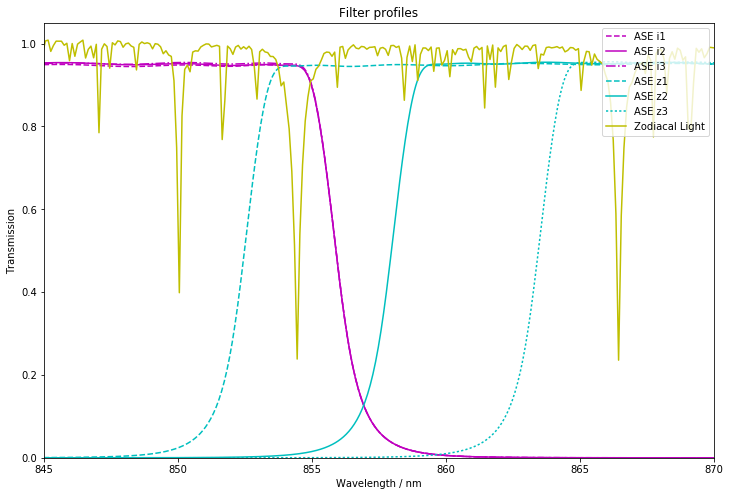

In [56]:
plt.plot(waves_a, ase_2016.filters['ase_i1'].transmission(waves_a), 'm--', label='ASE i1')
plt.plot(waves_a, ase_2016.filters['ase_i2'].transmission(waves_a), 'm-', label='ASE i2')
plt.plot(waves_a, ase_2016.filters['ase_i3'].transmission(waves_a), 'm-.', label='ASE i3')

plt.plot(waves_a, ase_2016.filters['ase_z1'].transmission(waves_a), 'c--', label='ASE z1')
plt.plot(waves_a, ase_2016.filters['ase_z2'].transmission(waves_a), 'c-', label='ASE z2')
plt.plot(waves_a, ase_2016.filters['ase_z3'].transmission(waves_a), 'c:', label='ASE z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 *ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

The 'virtual narrowband filters' that result from the pair-wise differences between the 3 z band filters coincide with the strongest Ca-triplet absorption line and adjacent continuum.  Meaurements of the sky background in these 3 filters therefore allow a measurement of the depth of the Ca-triplet absorption.

The Zodical Light is expected to have equal Ca-triplet depth to the Solar spectrum while the extragalactic background light will not exhibit any absorption lines. Consequently a measurement of the sky background Ca-triplet absorption depth allows the separation of Zodical Light and extragalactic components.

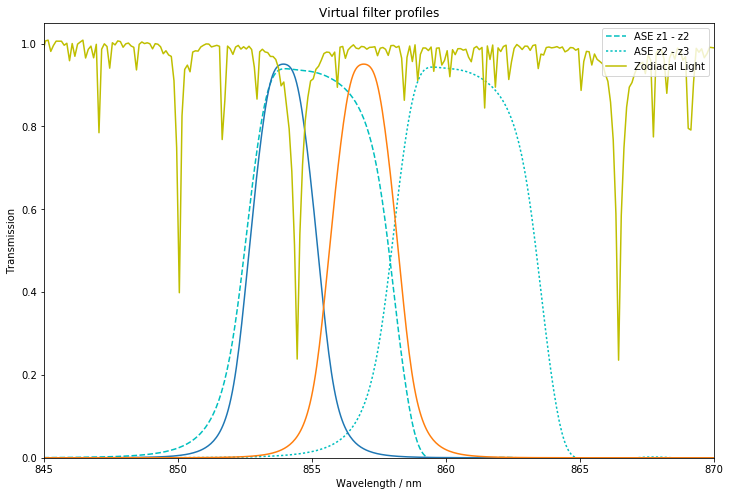

In [57]:
plt.plot(waves_a, 
         ase_2016.filters['ase_z1'].transmission(waves_a) - ase_2016.filters['ase_z2'].transmission(waves_a),
         'c--', label='ASE z1 - z2')
plt.plot(waves_a,
         ase_2016.filters['ase_z2'].transmission(waves_a) - ase_2016.filters['ase_z3'].transmission(waves_a),
         'c:', label='ASE z2 - z3')

plt.plot(waves_a, ase_2017.filters['ase_nb855'].transmission(waves_a))
plt.plot(waves_a, ase_2017.filters['ase_nb858'].transmission(waves_a))

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 * ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 
         'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Virtual filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

*EBL measurement sensitivity calculations to go here*

## Virtual narrowband filters for cosmic web H-alpha

Similar to the Calcium triplet measurements with the z-band filter variants the blue edge of the i-band filter variants allow virtual narrowband imaging around 692 nm. We hope to use this detect redshifted H-alpha emission from the cosmic web at $z=0.05$.

In [58]:
Ha = 656.28 * u.nm
z = 0.05
Ha * (1 + z)

<Quantity 689.094 nm>

In [59]:
Ha * (1 + 0.0583)

<Quantity 694.541124 nm>

Close up of the blue edge of the 3 i-band filter variants, shown together with the Zodiacal Light spectrum and the wavelength of H-alpha at $z=0.05$ and $z=0.0583$.

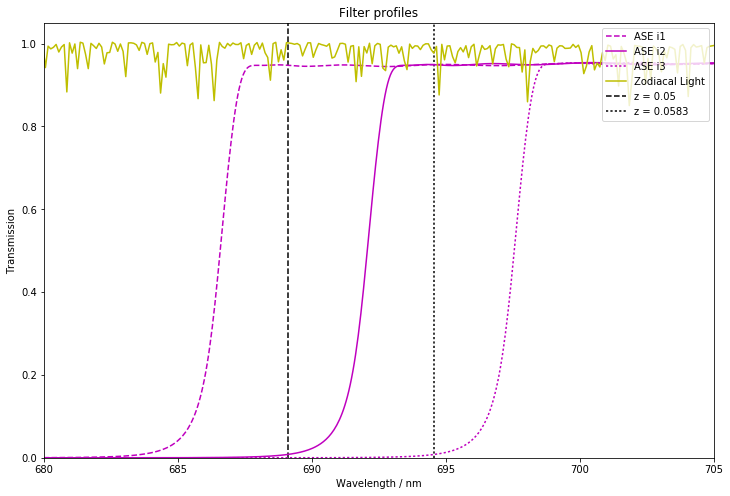

In [80]:
plt.plot(waves_a, ase_2016.filters['ase_i1'].transmission(waves_a), 'm--', label='ASE i1')
plt.plot(waves_a, ase_2016.filters['ase_i2'].transmission(waves_a), 'm-', label='ASE i2')
plt.plot(waves_a, ase_2016.filters['ase_i3'].transmission(waves_a), 'm:', label='ASE i3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.01 * ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(),
         'y-', label='Zodiacal Light')

plt.vlines(Ha.value * (1 + 0.05), 0, 1.05, linestyles='dashed', label='z = 0.05')
plt.vlines(Ha.value * (1 + 0.0583), 0, 1.05, linestyles='dotted', label='z = 0.0583')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(680, 705)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

The by comparing the two 'virtual narrowband filters' that result from the pair-wise differences between these i band variants we are able to distinguish between line emission and continuum at these wavelengths.

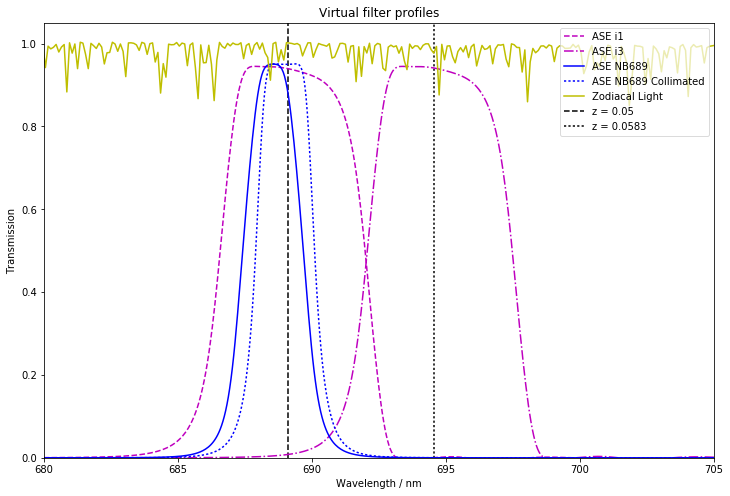

In [70]:
plt.plot(waves_a,
         ase_2016.filters['ase_i1'].transmission(waves_a) - ase_2016.filters['ase_i2'].transmission(waves_a),
         'm--', label='ASE i1')
plt.plot(waves_a,
         ase_2016.filters['ase_i2'].transmission(waves_a) - ase_2016.filters['ase_i3'].transmission(waves_a),
         'm-.', label='ASE i3')

plt.plot(waves_a, ase_2017.filters['ase_nb689'].transmission(waves_a), 'b-', label='ASE NB689')
plt.plot(waves_a, ase_2017.filters['ase_nb689'].transmission(waves_a, theta_range=(0, 0) * u.degree),
         'b:', label='ASE NB689 Collimated')
#plt.plot(waves_a, ase_2017.filters['ase_nb691'].transmission(waves_a), 'b-', label='ASE NB691')

plt.plot(ase_2016.sky.waves.to(u.nm), 1.01 *ase_2016.sky.photon_sfd/ase_2016.sky.photon_sfd.max(), 'y-', label='Zodiacal Light')

plt.vlines(Ha.value * (1 + 0.05), 0, 1.05, linestyles='dashed', label='z = 0.05')
plt.vlines(Ha.value * (1 + 0.0583), 0, 1.05, linestyles='dotted', label='z = 0.0583')

plt.legend(loc='upper right', fancybox=True, framealpha=0.7)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Virtual filter profiles')
plt.xlim(680, 705)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

In this mode we would be effectively be measuring the line emission signal via one of the i band filters with noise contributions from all three. Each of the filters will contribute very similar noise so can estimate the sensitivity of this virtual narrowband imaging mode simply by scaling the signal to noise ratio by $\sqrt3$.

Fortunately we can use substantial spatial binning for imaging the cosmic web, perhaps as large as 0.5$^\circ$ scales. Here we calculate the sensitivity for a SNR target of 5.0 per 0.5 x 0.5 degree given 3 months on target.  We convert from AB magnitudes per square arcsecond to total flux surface brightness in both SI and cgs units.

In [63]:
Ha_filter_fraction = 1 / 6

#### 6U ASE with 1x 90 mm telescope

In [64]:
Ha_90 = ase_2016.extended_source_limit(total_exp_time = 3 * 30 * u.day * duty_cycle * Ha_filter_fraction,
                                       sub_exp_time = 40 * u.minute,
                                       filter_name = 'ase_i2',
                                       snr_target=3**0.5 * 5.0 / 1800,
                                       calc_type='per arcsecond squared')
Ha_90 = ase_2016.ABmag_to_flux(Ha_90, 'ase_i2') / u.arcsecond**2
Ha_90 = Ha_90.to(u.W / (u.m**2 * u.steradian))
Ha_90

<Quantity 7.928657018420552e-13 W / (m2 sr)>

In [65]:
Ha_90.to(u.cgs.erg / (u.second * u.cm**2 * u.arcsecond**2))

<Quantity 1.863585681577968e-20 erg / (arcsec2 cm2 s)>

### Comment

Note that binning to this degree only leaves a few spatial elements across the field of view, and still requires many months on each just to reach the bright end of the predictions for cosmic web H-alpha ($\sim 10^{-20}$erg cm$^{-2}$ s$^{-1}$).

In [66]:
ase_2017.field_of_view

<Quantity [ 1.60428183, 1.20641993] deg>

In [81]:
import numpy as np

In [105]:
t = np.arange((0*u.degree)**2, (10 * u.degree)**2, (0.5 *u.degree)**2)**0.5

ValueError: setting an array element with a sequence.

In [101]:
t

<Quantity [  0.        ,  3.33333333,  4.71404521,  5.77350269,
             6.66666667,  7.45355992,  8.16496581,  8.81917104,
             9.42809042, 10.        ] deg>

In [102]:
850 * u.nm * (1 - np.sin(t/1.75)**2)**0.5

<Quantity [ 850.        , 849.53033839, 849.06076329, 848.5912747 ,
            848.12187259, 847.65255696, 847.1833278 , 846.71418511,
            846.24512886, 845.77615906] nm>